# Prueba de Verosimilitud Logarítmica

En este cuaderno se realizará la implementación de una prueba de verosimilitud logarítmica orientada a la generación de resúmenes, y se evaluará su desempeño con respecto a los resumenes de referencia.

Para la implementación de esta técnica, se realizarán las siguientes fases:

1. Cargar datos.
2. Aplicar el preprocesamiento al nuevo corpus.
3. Crear diccionarios para relacionar frases e identificadores 
4. Calcular matriz de verosimilitud logarítmica.
5. Determinar umbral para topic signatures.
    1. Ajustar topic signatures a un solo texto.
    2. Seleccionar frases.
    3. Mostrar resumenes.
    4. Evaluar el resumen obtenido.
    5. Gráficas.
6. Determinar longitud del resumen.
    1. Seleccionar frases.
    2. Mostrar resumenes.
    3. Evaluar el resumen obtenido.
    4. Gráficas.
7. Exportar datos 

In [1]:
#Importar elementos necesarios de las librerías
import os, shutil, re, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sys import setrecursionlimit
from rouge import Rouge
from nltk.corpus import PlaintextCorpusReader
from nltk.stem.snowball import SpanishStemmer
from scipy.stats import binom
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

#Aumentar la el limite de la recursión
setrecursionlimit(10**5)

In [2]:
#directorio actual
actual_dir = os.getcwd()

#Ruta del corpus
ruta = actual_dir + "\\textos"

#ruta de los resumenes de referencia
ruta_referencias = actual_dir + "\\referencias"

In [3]:
#Funciones auxiliares

def tokenize_sentence(path, file_name):
    #Retorna un documento tokenizado por frases
    doc = []
    text = PlaintextCorpusReader(path, file_name)
    paragraphs = text.paras()
    for paragraph in paragraphs:
        for sentence in paragraph:
            low, i = 0,0
            while i < len(sentence):
                token = sentence[i].split('.')
                if len(token)-1:
                    doc.append(sentence[low:i])
                    low=i+1
                    i+=2
                else:
                    i+=1
            if low!=i-1:
                doc.append(sentence[low:i])
    return doc

def preprocess(doc, stopwords, stemmer):
    #Aplica el preprocesamiento establecido
    #Adicionalmente, retorna el documento original sin las filas vacías por el preprocesamiento 
    doc_preprocesed, doc_reduced = [], []
    for original_sentence in doc:
        preprocessed_sentence = []
        for token in original_sentence:
            if stemmer.stem(token) not in stopwords:
                preprocessed_sentence.append(stemmer.stem(token))
        if len(preprocessed_sentence) and preprocessed_sentence not in doc_preprocesed:
            doc_preprocesed.append(preprocessed_sentence)
            doc_reduced.append(original_sentence)
    return doc_preprocesed, doc_reduced

def get_dictionaries(doc):
    #Retorna un par de diccionarios que relacionan una frase con un id, y un id con una frase.
    sentence2id, id2sentence = {},{}
    n_sentences = len(doc)
    for i in range(n_sentences):
        sentence = ' '.join(doc[i])
        if sentence not in sentence2id:
            sentence2id[sentence] = i
            id2sentence[i] = sentence
    return sentence2id, id2sentence

def reverse_dict(dictionary):
    #Invierte el sentido de un diccionario
    reverse = {}
    for k,v in dictionary.items():
        reverse[v] = k
    return reverse

def log_likelihood_ratio(bag_of_words,id2token,texts):
    #Calcula la matriz -2 lambda
    tokens_per_document = bag_of_words.sum(1)
    ocurrences = bag_of_words.sum(0)
    total_tokens = bag_of_words.sum(0).sum(1)[0,0]
    n_documents,m_tokens = bag_of_words.shape
    loglikelihood_general = []
    for i in range(m_tokens):
        ocurrences_general = ocurrences[0,i]
        loglikelihood = binom.pmf(ocurrences_general, total_tokens,ocurrences_general/total_tokens)
        loglikelihood_general.append(loglikelihood)
    data = []
    for i in range(n_documents):
        row = []
        tokens_input = tokens_per_document[i,0]
        tokens_background = total_tokens - tokens_input
        for j in range(m_tokens):
            ocurrences_total = ocurrences[0,j]
            ocurrences_input = bag_of_words[i,j]
            ocurrences_background = ocurrences_total - ocurrences_input
            loglikelihood_input = binom.pmf(ocurrences_input, tokens_input, ocurrences_input/tokens_input)
            loglikelihood_background = binom.pmf(ocurrences_background, tokens_background, ocurrences_background/tokens_background)
            ratio = loglikelihood_general[j]/(loglikelihood_input*loglikelihood_background)
            #if ratio>5 and i==texts.index("segurosbolivar-privacidad.txt"):
            #    print(id2token[j])
            #    print("numerador: ",loglikelihood_general[j])
            #    print("denominador: ",loglikelihood_input*loglikelihood_background)
            #    print("lambda: ",ratio)
            #    print("frecuencia texto: ",ocurrences_input)
            #    print("frecuencia total: ",ocurrences_total)
            #    print()
            #Luego de las pruebas borrar parametro id2token
            row.append(ratio)
        data.append(row)
    lambda_matrix = np.array(data,dtype=np.float64)
    lambda_log_matrix = np.log(data)
    lambda_matrix_2 = lambda_matrix*-2
    lambda_log_matrix_2 = lambda_log_matrix*-2
    return lambda_matrix, lambda_log_matrix, lambda_matrix_2, lambda_log_matrix_2
    #Corregir posteriormente para solo retornar una de estas

def corpus_topic_signatures(log_likelihood_matrix, treshold):
    #Crea una matriz con los topic signatures a partir de la matriz -2lambda y el umbral
    data, col_index, row_index = [],[],[]
    n_documents, m_tokens = log_likelihood_matrix.shape
    for i in range(n_documents):
        for j in range(m_tokens):
            if log_likelihood_matrix[i,j] >= treshold:
                row_index.append(i)
                col_index.append(j)
                data.append(1)
    data = np.array(data)
    row_index = np.array(row_index)
    col_index = np.array(col_index)
    topic_signatures = csr_matrix((data,(row_index,col_index)),shape=(n_documents, m_tokens),dtype=np.float64)
    return topic_signatures

def document_topic_signatures(document, topic_signatures, token2id, doc_id):
    #Construye una matriz de un solo documento de acuerdo a la matriz de topic signatures 
    data,row_index,col_index = [],[],[]
    topic_signatures = topic_signatures.toarray()
    n_sentences, m_tokens = len(document), len(token2id)
    for i in range(n_sentences):
        sentence = document[i]
        j = 0
        for token in sentence:
            if token in token2id and topic_signatures[doc_id,token2id[token]] == 1:
                if (j==0) or (j>0 and token2id[token] not in col_index[-j:]):
                    topic_signature_value = topic_signatures[doc_id,token2id[token]]
                    data.append(topic_signature_value)
                    row_index.append(i)
                    col_index.append(token2id[token])
                    j+=1
    data = np.array(data)
    row_index = np.array(row_index)
    col_index = np.array(col_index)
    topic_signatures_document = csr_matrix((data,(row_index,col_index)),shape=(n_sentences, m_tokens),dtype=np.float64)
    return topic_signatures_document

def generate_summary(topic_signatures, n_sentences, sentence2id):
    #Genera un resumen con un total de n_sentences frases
    total_sentences = topic_signatures.shape[0]
    assert n_sentences < total_sentences
    topic_signatures = topic_signatures.toarray().sum(1)
    df = pd.DataFrame(topic_signatures,columns = ['topic signatures'])
    df['sentence'] = sentence2id.keys()
    df = df.sort_values(by='topic signatures', ascending = False)
    summary = []
    i,flag=0,1
    while i < n_sentences and flag:
        sentence = df.iloc[i]['sentence']
        flag = df.iloc[i]['topic signatures']
        if flag:
            summary.append(sentence)
        i+=1
    assert summary != []
    return summary

def read_reference(path, filename):
    #Lee un resumen de referencia
    text = PlaintextCorpusReader(path, filename)
    text = text.paras()
    flat = []
    for sentences in text:
        for sentence in sentences:
            flat_sentence = ' '.join(sentence)
            flat.append(flat_sentence)
    reference = ' '.join(flat)
    return reference

## Fase 1. Cargar datos

In [4]:
#Cargar las stopwords obtenido en preprocesamiento.
filename = 'stopwords.pkl'
stopwords = pickle.load(open(filename, 'rb'))

#Carga el corpus usado para el preprocesamiento
filename = 'corpus_single_string.pkl'
corpus_single_string = pickle.load(open(filename, 'rb'))

## Fase 2. Aplicar preprocesamiento
### Tokenización por frases

In [5]:
stemmer = SpanishStemmer()

corpus = []

referencias = os.listdir(ruta_referencias)

n_referencias = len(referencias)

for doc in referencias:
    documento = tokenize_sentence(ruta, doc)
    corpus.append(documento)

n_referencias

41

### Stopwords y Stemming

In [6]:
corpus_preprocesado = []
for i in range(n_referencias):
    doc_preprocesado, corpus[i] = preprocess(corpus[i], stopwords, stemmer)
    corpus_preprocesado.append(doc_preprocesado)

## Fase 3. Crear diccionarios para relacionar frases e identificadores 

In [7]:
frase2id, id2frase = [],[]

for i in range(n_referencias):
    f2id, id2f = get_dictionaries(corpus[i])
    frase2id.append(f2id)
    id2frase.append(id2f)

## Fase 4. Calcular matriz de verosimilitud logarítmica

In [8]:
vectorizer = CountVectorizer(stop_words = stopwords)

bag_of_words = vectorizer.fit_transform(corpus_single_string)

#Diccionario que relaciona tokens con un identificador único
token2id = vectorizer.vocabulary_

#Diccionario que un identificador con un token
id2token = reverse_dict(token2id)

In [9]:
textos = os.listdir(ruta)
lambda_matrix, lambda_log_matrix, lambda_matrix_2, lambda_log_matrix_2 = log_likelihood_ratio(bag_of_words,id2token,textos)

In [10]:
lambda_matrix.shape

(56, 4740)

In [11]:
#Lista de textos dentro del corpus
textos = os.listdir(ruta)

indice_bolivar = textos.index('segurosbolivar-privacidad.txt')

lambda_bolivar = lambda_matrix.tolist()[indice_bolivar]
lambda_log_bolivar = lambda_log_matrix.tolist()[indice_bolivar]
lambda_bolivar_2 = lambda_matrix_2.tolist()[indice_bolivar]
lambda_log_bolivar_2 = lambda_log_matrix_2.tolist()[indice_bolivar]

data = [[id2token[i],lambda_bolivar[i],lambda_log_bolivar[i],
         lambda_bolivar_2[i],lambda_log_bolivar_2[i]] for i in range(len(lambda_bolivar))]

df = pd.DataFrame(data,columns=['token','lambda','log lambda','-2 lambda','-2 log lambda'])
df_top = df.sort_values(by='lambda', ascending = False).head(10)
df_top

,token,lambda,log lambda,-2 lambda,-2 log lambda
1176,dat,10.963690,2.394589,-21.927381,-4.789178
4443,tratamient,9.357990,2.236231,-18.715980,-4.472461
836,compañ,9.061214,2.204003,-18.122429,-4.408006
3267,personal,7.874946,2.063686,-15.749891,-4.127373
1923,final,7.315323,1.989971,-14.630646,-3.979942
537,boliv,7.034832,1.950874,-14.069663,-3.901748
2090,grup,6.786006,1.914863,-13.572011,-3.829725
2343,inform,6.653647,1.895165,-13.307293,-3.790330
75,activ,6.600706,1.887177,-13.201412,-3.774353
1270,desarroll,6.509820,1.873312,-13.019640,-3.746624


Text(0, 0.5, '-2 log lambda')

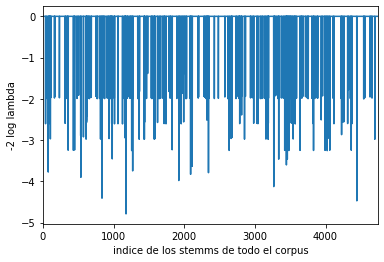

In [12]:
grafica = df.plot(y=['-2 log lambda'],legend=False)
grafica.set_xlabel('indice de los stemms de todo el corpus')
grafica.set_ylabel('-2 log lambda')

Text(0, 0.5, 'lambda')

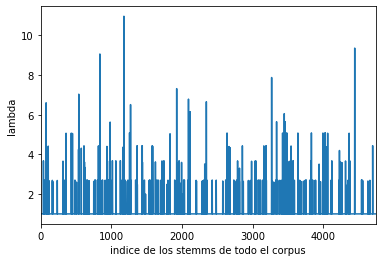

In [13]:
grafica = df.plot(y=['lambda'],legend=False)
grafica.set_xlabel('indice de los stemms de todo el corpus')
grafica.set_ylabel('lambda')

## Fase 5. Determinar umbral para topic signatures. 

In [14]:
#Umbrales asociados a la tabla chi2 con un grado de libertad
#y niveles de significancia 0.025, 0.010, 0.005, 0.001 respectivamente
umbrales = [5.0239,6.6349,7.8794,10.8276]

topic_signatures_umbrales = []

for umbral in umbrales:
    topic_signatures = corpus_topic_signatures(lambda_matrix,umbral)
    topic_signatures_umbrales.append(topic_signatures)

### Comprobar cantidad de topic signatures encontradas dentro del corpus

umbral:  5.0239
[230. 158. 108. 143. 148.  56. 142. 440. 220. 147.  36.  29. 114. 131.
 166. 102. 118. 136.  14.  10. 109. 228. 136. 135. 189.  18.  79. 158.
  97.  49.  64. 205. 156.  94. 149. 327. 204. 101.  29. 264. 154. 261.
 148.  44. 180. 171. 126. 112.  41. 262. 198. 214. 182. 134. 105. 193.]

umbral:  6.6349
[110.  85.  48.  76.  80.  21.  53. 278. 114.  68.  12.   6.  60.  68.
  80.  51.  63.  66.   3.   4.  41. 110.  58.  71. 106.   2.  41.  80.
  43.  23.  25. 111.  86.  37.  71. 183.  96.  43.   8. 152.  78. 149.
  72.  20.  81.  67.  53.  48.  14. 147. 118. 109.  99.  65.  56. 105.]

umbral:  7.8794
[ 65.  50.  31.  47.  50.  10.  29. 199.  74.  40.   6.   3.  37.  49.
  51.  23.  43.  42.   2.   1.  23.  84.  32.  43.  71.   2.  20.  52.
  25.  16.  16.  71.  57.  24.  41. 117.  56.  25.   3. 103.  47.  89.
  41.  13.  51.  33.  31.  30.   8. 104.  80.  70.  69.  41.  34.  68.]

umbral:  10.8276
[32. 17. 11. 19. 27.  3.  8. 93. 27. 14.  1.  0. 10. 20. 19.  9.  8. 19.
  0.

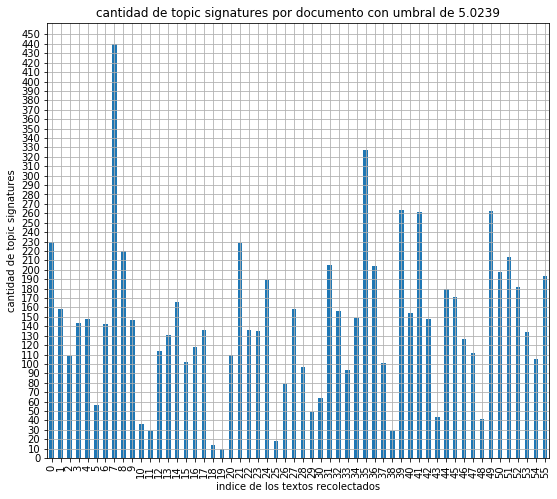

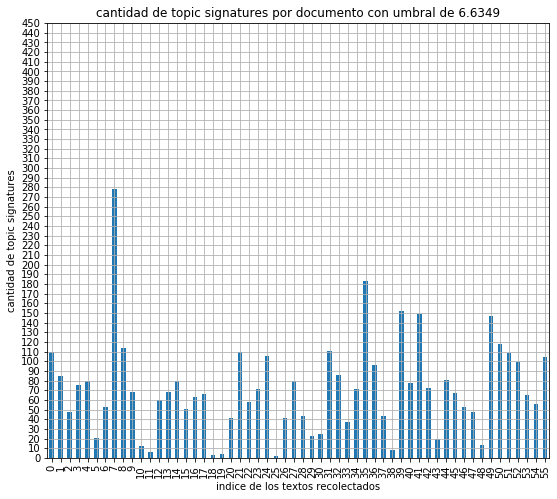

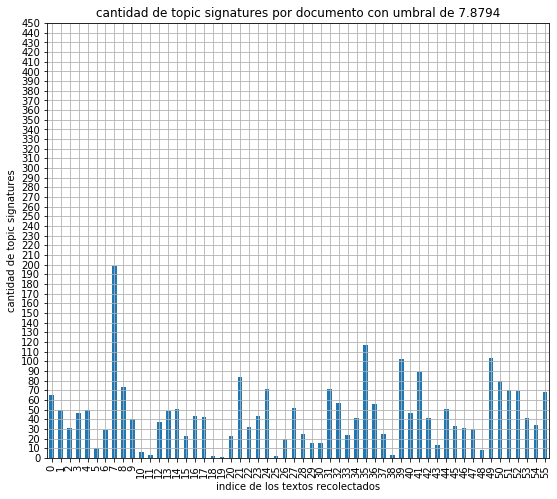

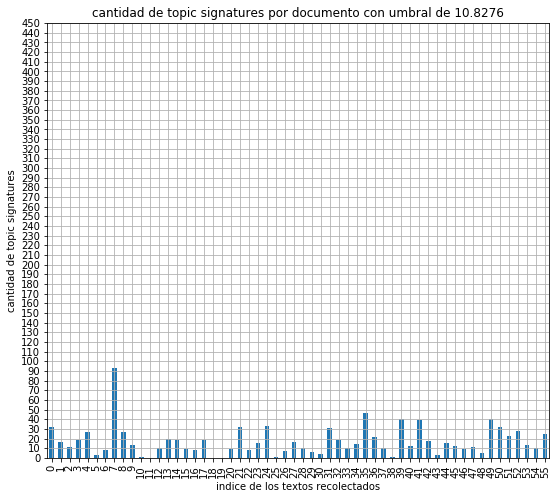

In [15]:
#Pruebas para mirar la cantidad de topic signatures dentro de todo el corpus de acuerdo al umbral establecido

for i in range(len(umbrales)):
    print('umbral: ',umbrales[i])
    topic_signatures_por_documento = topic_signatures_umbrales[i].toarray().sum(1)
    print(topic_signatures_por_documento)
    print()
    df_umbral = pd.DataFrame(topic_signatures_por_documento, columns=['topic signatures por documento {}'.format(umbrales[i])])
    grafica = df_umbral.plot.bar(figsize=(9,8),grid=True,yticks=np.arange(0,460,10),legend=False,
                                 title='cantidad de topic signatures por documento con umbral de {}'.format(umbrales[i]))
    grafica.set_xlabel('indice de los textos recolectados')
    grafica.set_ylabel('cantidad de topic signatures')

In [16]:
#Se decide no experimentar con el umbral de 10.8276
umbrales.pop()
topic_signatures_umbrales.pop()

<56x4740 sparse matrix of type '<class 'numpy.float64'>'
	with 972 stored elements in Compressed Sparse Row format>

### Comprobar cantidad de topic signatures encontradas dentro del corpus (solo los que fueron resumidos)

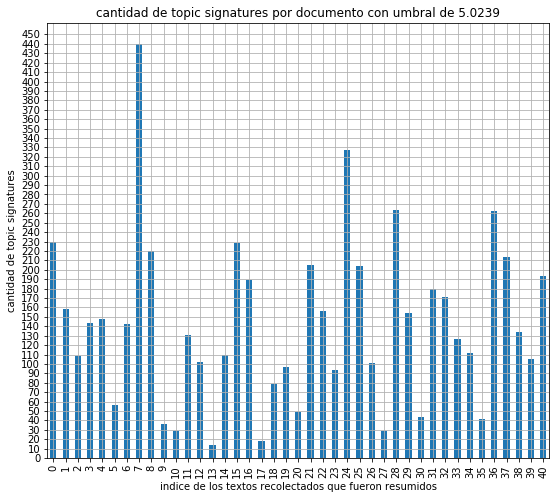

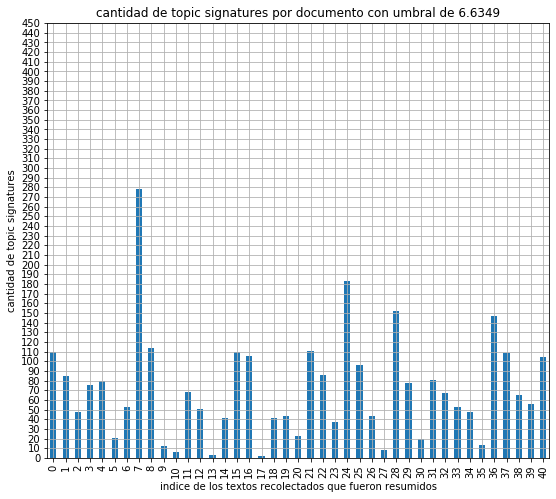

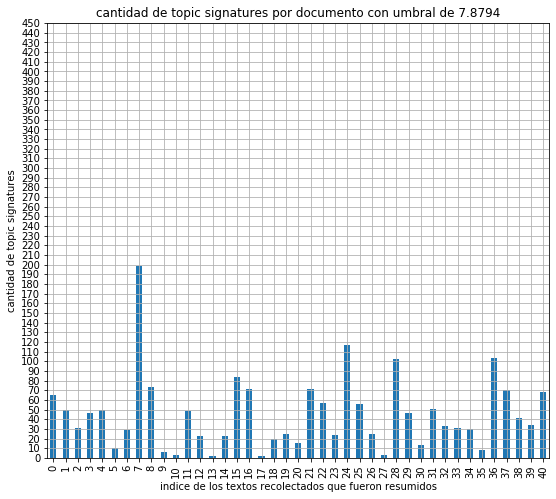

In [17]:
textos_recolectados = os.listdir(ruta)
textos_referencias = os.listdir(ruta_referencias)

i,j,filtro = 0,0,[]
while i< len(textos_recolectados) and j < len(textos_referencias):
    if textos_recolectados[i] ==  textos_referencias[j]:
        filtro.append(1)
        j+=1
    else:
        filtro.append(0)
    i+=1
    
for i in range(len(umbrales)):
    topic_signatures_por_documento = topic_signatures_umbrales[i].toarray().sum(1)
    df_umbral = pd.DataFrame(topic_signatures_por_documento, columns=['topic signatures por documento {}'.format(umbrales[i])])
    df_umbral = df_umbral[[x == 1 for x in filtro]]
    df_umbral = df_umbral.reset_index()
    df_umbral.drop('index',axis=1,inplace=True)
    grafica = df_umbral.plot.bar(figsize=(9,8),grid=True,yticks=np.arange(0,460,10),legend=False,
                                 title='cantidad de topic signatures por documento con umbral de {}'.format(umbrales[i]))
    grafica.set_xlabel('indice de los textos recolectados que fueron resumidos')
    grafica.set_ylabel('cantidad de topic signatures')

## Fase 5.A Ajustar topic signatures a un solo texto.

In [18]:
#Lista de textos dentro del corpus
textos = os.listdir(ruta)

topic_signatures_corpus = []

for i in range(n_referencias):
    topic_signatures_texto = []
    for j in range(len(umbrales)):
        topic_signatures = document_topic_signatures(corpus_preprocesado[i], topic_signatures_umbrales[j], token2id, textos.index(referencias[i]))
        topic_signatures_texto.append(topic_signatures)
    topic_signatures_corpus.append(topic_signatures_texto)

## Fase 5.B Seleccionar frases

In [19]:
resumenes_corpus = []

for i in range(n_referencias):
    resumen_texto = []
    for j in range(len(umbrales)):
        resumen = generate_summary(topic_signatures_corpus[i][j], 5, frase2id[i])
        resumen = '. '.join(resumen)
        resumen_texto.append(resumen)
    resumenes_corpus.append(resumen_texto)

## Fase 5.C Mostrar resumenes

In [20]:
for i in range(n_referencias):
    print(referencias[i])
    for j in range(len(umbrales)):
        print(umbrales[j])
        print(resumenes_corpus[i][j])
        print()
    print()

adobe-condiciones.txt
5.0239
Si recibió un “ Derecho ” ( que se define como el derecho a usar y consumir el Software y los Servicios , y a acceder a ellos ) de una organización o grupo , que incluye , entre otros , una compañía o cualquier otra entidad comercial , entidad de la administración pública , organización sin fines de lucro o institución educativa ( cada una de ellas denominada “ Compañía ”) según uno de los planes comerciales de Adobe ( como Creative Cloud para equipos , Creative Cloud para compañías o Document Cloud ), entonces ( A ) usted es un “ Usuario empresarial ” de dicha Compañía ; ( B ) su perfil de Adobe asociado con dicho Derecho es un “ Perfil empresarial ”; y ( C ) todas las referencias a “ usted ” en estas Condiciones significarán dicha Compañía. Si usted es un Usuario empresarial , acepta que , debido a la recepción de Derechos de dicha Compañía , ( 1 ) Adobe puede proporcionar a dicha Compañía la capacidad de usar , eliminar , retener y controlar su Perfil em

## Fase 5.D Evaluar el resumen obtenido

In [22]:
resumenes_referencia = []

for doc in referencias:
    referencia_doc = read_reference(ruta_referencias, doc)
    resumenes_referencia.append(referencia_doc) 

rouge = Rouge(metrics=["rouge-1", "rouge-l"])

In [23]:
puntajes_corpus = [[] for _ in range(len(umbrales))]

for i in range(n_referencias):
    print(referencias[i])
    for j in range(len(umbrales)):
        print(umbrales[j])
        puntajes_documento = rouge.get_scores(resumenes_corpus[i][j], resumenes_referencia[i])
        puntajes_corpus[j].append(puntajes_documento)
        print(puntajes_documento)
    print()

adobe-condiciones.txt
5.0239
[{'rouge-1': {'f': 0.49495732643073437, 'p': 0.6053130929791272, 'r': 0.41863517060367456}, 'rouge-l': {'f': 0.28305399888087834, 'p': 0.3438914027149321, 'r': 0.24050632911392406}}]
6.6349
[{'rouge-1': {'f': 0.5367362673946989, 'p': 0.6534839924670434, 'r': 0.4553805774278215}, 'rouge-l': {'f': 0.42447418259767705, 'p': 0.5362318840579711, 'r': 0.3512658227848101}}]
7.8794
[{'rouge-1': {'f': 0.5485799652012575, 'p': 0.6371527777777778, 'r': 0.4816272965879265}, 'rouge-l': {'f': 0.41726618214378147, 'p': 0.48333333333333334, 'r': 0.3670886075949367}}]

adobe-privacidad.txt
5.0239
[{'rouge-1': {'f': 0.5503258462053493, 'p': 0.4323094425483504, 'r': 0.7569721115537849}, 'rouge-l': {'f': 0.4763705054634596, 'p': 0.4271186440677966, 'r': 0.5384615384615384}}]
6.6349
[{'rouge-1': {'f': 0.5532544332010872, 'p': 0.44, 'r': 0.7450199203187251}, 'rouge-l': {'f': 0.4912959331493627, 'p': 0.44876325088339225, 'r': 0.5427350427350427}}]
7.8794
[{'rouge-1': {'f': 0.5686

## Fase 5.E. Gráficas

In [24]:
metricas=['rouge-1','rouge-l']

puntajes_por_umbral = []
for i in range(len(umbrales)):
    puntajes_por_metrica = [[],[]]
    for j in range(len(metricas)):
        for k in range(n_referencias):
            m = metricas[j]
            f_score = puntajes_corpus[i][k][0][m]['f']
            precision = puntajes_corpus[i][k][0][m]['p']
            recall = puntajes_corpus[i][k][0][m]['r']
            puntajes_por_metrica[j].append((f_score,precision,recall))
    puntajes_por_umbral.append(puntajes_por_metrica)
    
metricas = ['f-score','precision','recall']

### Comparación Rouge-1

In [25]:
df_rouge1 = pd.DataFrame(puntajes_por_umbral[0][0], columns=['f-score 5.0239','precision 5.0239','recall 5.0239'])
for i in range(1,len(umbrales)):
    tmp = pd.DataFrame(puntajes_por_umbral[i][0],
                       columns=['f-score {}'.format(umbrales[i]),'precision {}'.format(umbrales[i]),
                                'recall {}'.format(umbrales[i])])
    df_rouge1 = df_rouge1.join(tmp)

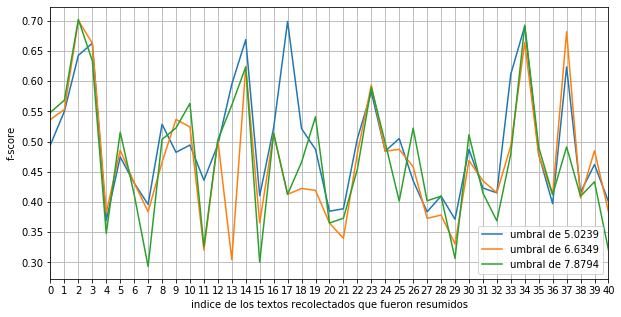

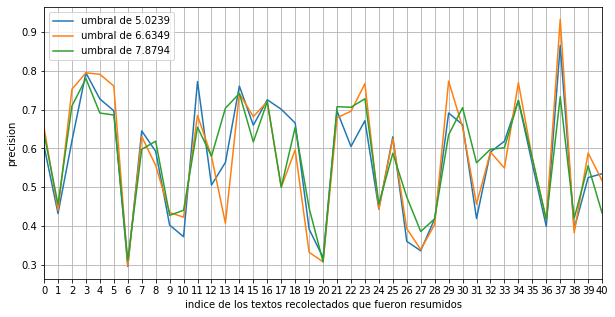

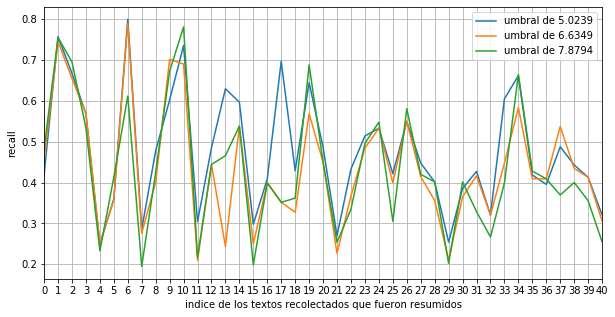

In [26]:
leyenda=['umbral de 5.0239','umbral de 6.6349','umbral de 7.8794']
for metrica in metricas:
    grafica = df_rouge1.plot(y=['{} 5.0239'.format(metrica),'{} 6.6349'.format(metrica),'{} 7.8794'.format(metrica)],
                             figsize=(10,5),grid=1,layout=(1,3),xticks=np.arange(0,n_referencias,1))
    grafica.set_xlabel('indice de los textos recolectados que fueron resumidos')
    grafica.set_ylabel(metrica)
    grafica.legend(leyenda)

In [27]:
df_rouge1.describe()

,f-score 5.0239,precision 5.0239,recall 5.0239,f-score 6.6349,precision 6.6349,recall 6.6349,f-score 7.8794,precision 7.8794,recall 7.8794
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.493303,0.570630,0.478068,0.467532,0.576631,0.435475,0.468587,0.578263,0.432406
std,0.094102,0.149232,0.144793,0.100542,0.161202,0.146820,0.103389,0.129513,0.156076
min,0.369835,0.295632,0.247922,0.304636,0.297534,0.209211,0.293454,0.307453,0.194465
25%,0.415308,0.419355,0.395380,0.384420,0.434783,0.351515,0.402116,0.456077,0.334740
50%,0.484132,0.605108,0.443011,0.465988,0.588235,0.412844,0.479730,0.598039,0.408967
75%,0.528841,0.691450,0.596702,0.513834,0.696000,0.537313,0.522727,0.704000,0.533955
max,0.699088,0.865342,0.799578,0.700552,0.933045,0.789030,0.702505,0.780156,0.780992


### Comparación Rouge-L

In [28]:
df_rougel = pd.DataFrame(puntajes_por_umbral[0][1], columns=['f-score 5.0239','precision 5.0239','recall 5.0239'])
for i in range(1,len(umbrales)):
    tmp = pd.DataFrame(puntajes_por_umbral[i][1],
                       columns=['f-score {}'.format(umbrales[i]),'precision {}'.format(umbrales[i]),
                                'recall {}'.format(umbrales[i])])
    df_rougel = df_rougel.join(tmp)

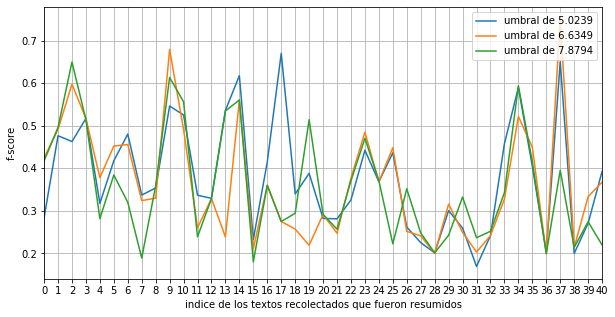

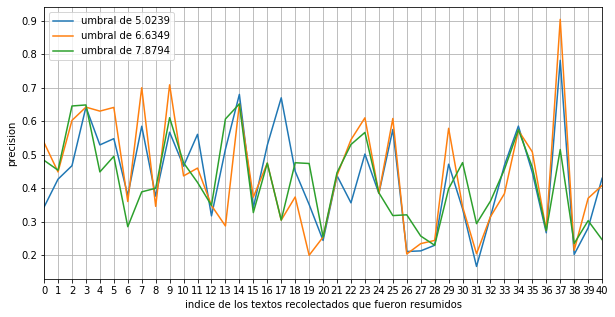

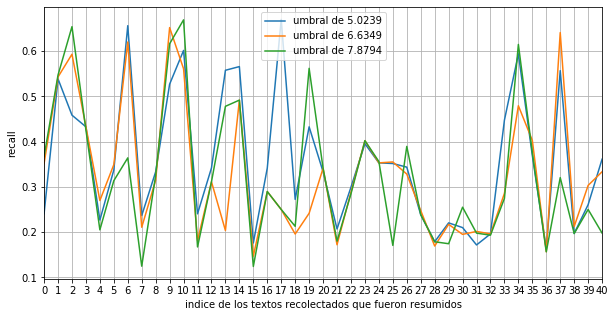

In [29]:
leyenda=['umbral de 5.0239','umbral de 6.6349','umbral de 7.8794']
for metrica in metricas:
    grafica = df_rougel.plot(y=['{} 5.0239'.format(metrica),'{} 6.6349'.format(metrica),'{} 7.8794'.format(metrica)],
                             figsize=(10,5),grid=1,layout=(1,3),xticks=np.arange(0,n_referencias,1))
    grafica.set_xlabel('indice de los textos recolectados que fueron resumidos')
    grafica.set_ylabel(metrica)
    grafica.legend(leyenda)

In [30]:
df_rougel.describe()

,f-score 5.0239,precision 5.0239,recall 5.0239,f-score 6.6349,precision 6.6349,recall 6.6349,f-score 7.8794,precision 7.8794,recall 7.8794
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.379058,0.430737,0.356887,0.364138,0.442250,0.328968,0.355235,0.422666,0.323057
std,0.131240,0.146185,0.147100,0.136753,0.168615,0.143063,0.130628,0.122699,0.151965
min,0.169118,0.166667,0.162939,0.199187,0.200000,0.146727,0.180033,0.229839,0.124153
25%,0.281022,0.338710,0.236559,0.249201,0.315068,0.210753,0.247619,0.318471,0.197761
50%,0.353607,0.437500,0.341463,0.329609,0.408511,0.303191,0.332248,0.446667,0.289634
75%,0.462783,0.529412,0.447368,0.452107,0.578947,0.402027,0.417266,0.483333,0.389313
max,0.670000,0.781818,0.670000,0.750000,0.904110,0.651786,0.649682,0.651786,0.668919


## Fase 6. Determinar longitud del resumen.

In [31]:
#Se opto por escoge como umbral de las topic signatures 5.0239 
indice_umbral = 0

## Fase 6.A Seleccionar frases

In [32]:
resumenes_corpus = []
cantidad_frases_resumen = [5,8,10]

for i in range(n_referencias):
    resumen_texto = []
    for cantidad_frases in cantidad_frases_resumen:
        resumen = generate_summary(topic_signatures_corpus[i][indice_umbral], cantidad_frases, frase2id[i])
        resumen = '. '.join(resumen)
        resumen_texto.append(resumen)
    resumenes_corpus.append(resumen_texto)

## Fase 6.B Mostrar resumenes

In [33]:
for i in range(n_referencias):
    print(referencias[i])
    for j in range(len(cantidad_frases_resumen)):
        print(cantidad_frases_resumen[j])
        print(resumenes_corpus[i][j])
        print()
    print()

adobe-condiciones.txt
5
Si recibió un “ Derecho ” ( que se define como el derecho a usar y consumir el Software y los Servicios , y a acceder a ellos ) de una organización o grupo , que incluye , entre otros , una compañía o cualquier otra entidad comercial , entidad de la administración pública , organización sin fines de lucro o institución educativa ( cada una de ellas denominada “ Compañía ”) según uno de los planes comerciales de Adobe ( como Creative Cloud para equipos , Creative Cloud para compañías o Document Cloud ), entonces ( A ) usted es un “ Usuario empresarial ” de dicha Compañía ; ( B ) su perfil de Adobe asociado con dicho Derecho es un “ Perfil empresarial ”; y ( C ) todas las referencias a “ usted ” en estas Condiciones significarán dicha Compañía. Si usted es un Usuario empresarial , acepta que , debido a la recepción de Derechos de dicha Compañía , ( 1 ) Adobe puede proporcionar a dicha Compañía la capacidad de usar , eliminar , retener y controlar su Perfil empresa

## Fase 6.C Evaluar el resumen obtenido.

In [34]:
rouge = Rouge(metrics=["rouge-1", "rouge-l"])
puntajes_corpus = [[] for _ in range(len(cantidad_frases_resumen))]

for i in range(n_referencias):
    print(referencias[i])
    for j in range(len(cantidad_frases_resumen)):
        print(cantidad_frases_resumen[j])
        puntajes_documento = rouge.get_scores(resumenes_corpus[i][j], resumenes_referencia[i])
        puntajes_corpus[j].append(puntajes_documento)
        print(puntajes_documento)
    print()

adobe-condiciones.txt
5
[{'rouge-1': {'f': 0.49495732643073437, 'p': 0.6053130929791272, 'r': 0.41863517060367456}, 'rouge-l': {'f': 0.28305399888087834, 'p': 0.3438914027149321, 'r': 0.24050632911392406}}]
8
[{'rouge-1': {'f': 0.5615336994073866, 'p': 0.5309941520467836, 'r': 0.5958005249343832}, 'rouge-l': {'f': 0.4043545828708257, 'p': 0.39755351681957185, 'r': 0.41139240506329117}}]
10
[{'rouge-1': {'f': 0.5093945672343436, 'p': 0.42287694974003465, 'r': 0.6404199475065617}, 'rouge-l': {'f': 0.39943342281697153, 'p': 0.36153846153846153, 'r': 0.4462025316455696}}]

adobe-privacidad.txt
5
[{'rouge-1': {'f': 0.5503258462053493, 'p': 0.4323094425483504, 'r': 0.7569721115537849}, 'rouge-l': {'f': 0.4763705054634596, 'p': 0.4271186440677966, 'r': 0.5384615384615384}}]
8
[{'rouge-1': {'f': 0.4937185886469092, 'p': 0.3605504587155963, 'r': 0.7828685258964143}, 'rouge-l': {'f': 0.44786324306324793, 'p': 0.3732193732193732, 'r': 0.5598290598290598}}]
10
[{'rouge-1': {'f': 0.4599303094581161

## Fase 6.D Gráficas

In [35]:
metricas=['rouge-1','rouge-l']

puntajes_por_cantidad_de_frases = []
for i in range(len(cantidad_frases_resumen)):
    puntajes_por_metrica = [[],[]]
    for j in range(len(metricas)):
        for k in range(n_referencias):
            m = metricas[j]
            f_score = puntajes_corpus[i][k][0][m]['f']
            precision = puntajes_corpus[i][k][0][m]['p']
            recall = puntajes_corpus[i][k][0][m]['r']
            puntajes_por_metrica[j].append((f_score,precision,recall))
    puntajes_por_cantidad_de_frases.append(puntajes_por_metrica)

metricas=['f-score','precision','recall']

### Comparación Rouge-1

In [36]:
df_rouge1 = pd.DataFrame(puntajes_por_cantidad_de_frases[0][0], columns=['f-score 5 frases','precision 5 frases','recall 5 frases'])
for i in range(1,len(cantidad_frases_resumen)):
    tmp = pd.DataFrame(puntajes_por_cantidad_de_frases[i][0],
                       columns=['f-score {} frases'.format(cantidad_frases_resumen[i]),
                                'precision {} frases'.format(cantidad_frases_resumen[i]),
                                'recall {} frases'.format(cantidad_frases_resumen[i])])
    df_rouge1 = df_rouge1.join(tmp)

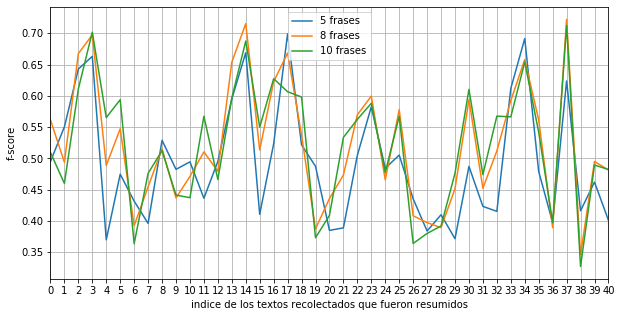

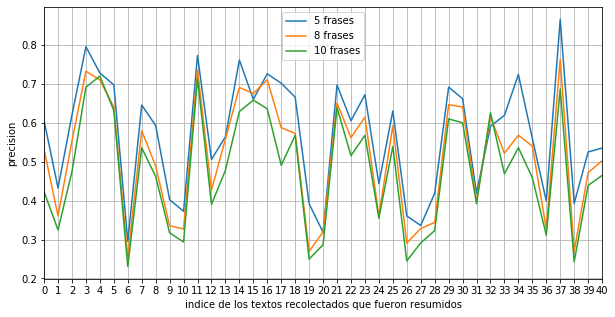

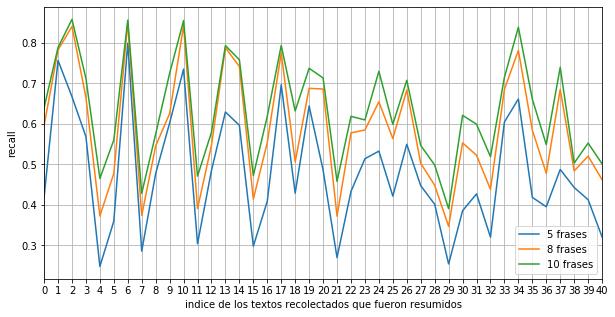

In [37]:
leyenda=['5 frases','8 frases','10 frases']
for metrica in metricas:
    grafica = df_rouge1.plot(y=['{} 5 frases'.format(metrica),'{} 8 frases'.format(metrica),'{} 10 frases'.format(metrica)],
                             figsize=(10,5),grid=1,layout=(1,3),xticks=np.arange(0,n_referencias,1))
    grafica.set_xlabel('indice de los textos recolectados que fueron resumidos')
    grafica.set_ylabel(metrica)
    grafica.legend(leyenda)

In [38]:
df_rouge1.describe()

,f-score 5 frases,precision 5 frases,recall 5 frases,f-score 8 frases,precision 8 frases,recall 8 frases,f-score 10 frases,precision 10 frases,recall 10 frases
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.493303,0.570630,0.478068,0.521584,0.513741,0.585361,0.519892,0.475804,0.634153
std,0.094102,0.149232,0.144793,0.099408,0.151576,0.143172,0.098537,0.148233,0.128741
min,0.369835,0.295632,0.247922,0.346420,0.255063,0.346995,0.327273,0.230813,0.390710
25%,0.415308,0.419355,0.395380,0.452268,0.360550,0.478261,0.459930,0.324590,0.546961
50%,0.484132,0.605108,0.443011,0.510309,0.553365,0.563898,0.533514,0.474315,0.619165
75%,0.528841,0.691450,0.596702,0.592233,0.640316,0.685393,0.593750,0.609808,0.730137
max,0.699088,0.865342,0.799578,0.722149,0.763158,0.850211,0.712148,0.719486,0.858471


### Comparación Rouge-L

In [39]:
df_rougel = pd.DataFrame(puntajes_por_cantidad_de_frases[0][1], columns=['f-score 5 frases','precision 5 frases','recall 5 frases'])
for i in range(1,len(cantidad_frases_resumen)):
    tmp = pd.DataFrame(puntajes_por_cantidad_de_frases[i][1],
                       columns=['f-score {} frases'.format(cantidad_frases_resumen[i]),
                                'precision {} frases'.format(cantidad_frases_resumen[i]),
                                'recall {} frases'.format(cantidad_frases_resumen[i])])
    df_rougel = df_rougel.join(tmp)

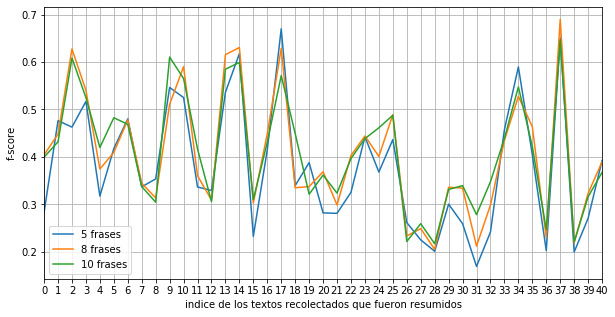

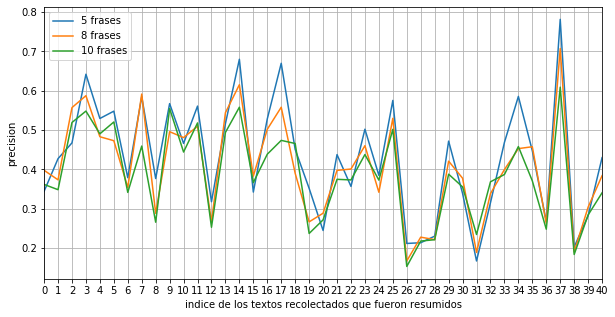

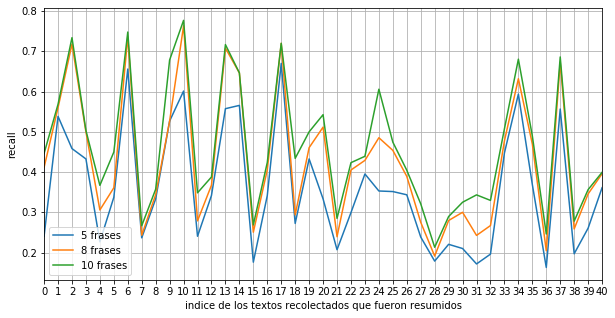

In [40]:
leyenda=['5 frases','8 frases','10 frases']
for metrica in metricas:
    grafica = df_rougel.plot(y=['{} 5 frases'.format(metrica),'{} 8 frases'.format(metrica),'{} 10 frases'.format(metrica)],
                             figsize=(10,5),grid=1,layout=(1,3),xticks=np.arange(0,n_referencias,1))
    grafica.set_xlabel('indice de los textos recolectados que fueron resumidos')
    grafica.set_ylabel(metrica)
    grafica.legend(leyenda)

In [41]:
df_rougel.describe()

,f-score 5 frases,precision 5 frases,recall 5 frases,f-score 8 frases,precision 8 frases,recall 8 frases,f-score 10 frases,precision 10 frases,recall 10 frases
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.379058,0.430737,0.356887,0.403872,0.405619,0.427471,0.410043,0.385431,0.462989
std,0.131240,0.146185,0.147100,0.128218,0.128922,0.165247,0.118452,0.115883,0.159755
min,0.169118,0.166667,0.162939,0.205042,0.166667,0.191223,0.216906,0.152738,0.213166
25%,0.281022,0.338710,0.236559,0.313487,0.303738,0.279605,0.321300,0.283898,0.343284
50%,0.353607,0.437500,0.341463,0.389744,0.397554,0.405109,0.416667,0.372990,0.434043
75%,0.462783,0.529412,0.447368,0.477922,0.495798,0.511628,0.482540,0.473684,0.568376
max,0.670000,0.781818,0.670000,0.689884,0.707483,0.763514,0.645358,0.609195,0.777027


## Fase 7. Exportar datos

In [42]:
#Guardar dataframe del ROUGE 1
filename = 'df_rouge1_LLR.pkl'
pickle.dump(df_rouge1, open(filename, 'wb'))

#Guardar dataframe del ROUGE L
filename = 'df_rougel_LLR.pkl'
pickle.dump(df_rougel, open(filename, 'wb'))

#Guardar resumenes
filename = 'resumenes_LLR.pkl'
pickle.dump(resumenes_corpus, open(filename, 'wb'))